# CS366 FINAL PROJECT

### From Archival Script to Accurate Sí: Reviving 19th-Century Spanish Manuscripts with Accent-Aware AI

**Shelby Roman**

In [23]:
# Import necessary libraries
import cv2
import matplotlib.pyplot as plt
import csv
import difflib
from collections import Counter
import numpy as np
from openai import OpenAI
import os
import pandas as pd
import json
import base64
# import re
from jiwer import cer
import unicodedata

### Abstract

In this project, I am trying to improve OpenAI's API in taking in images of handwritten Spanish text from the 1800s and outputing the text with accents included. These documents are written in a type of script that OCR (and humans) tend to have troubles correctly transcribing. Most of it is in a script/cursive type font, in which the letters blend together. The accents are especially important. In Spanish, “sí” with an accent means “yes”, while “si” without an accent means “if”. The absence or presence of the accent will change the meaning of a word/phrase/sentence entirely. So, I am focusing on ensuring that my model is as accurate with accents as it can be.

*Note: More detailed explanations of the various parts and steps of my project can be found in my project proposal/report. This file is meant to mostly contain code, with some general descriptions of what the code is doing.*

### Dataset

I downloaded 20 images of Spanish handwritten manuscripts from the 1800s. I asked OpenAI's ChatGPT 5.1 and Google's Gemini 2.5 Pro to transcribe each image. I then used these transcripts as a starting point to accurately transcribe the images (to the best of my abilities), making sure I fixed any mistakes that the AI tools had made. I then saved the correct transcript and the two AI generated transcriptions for all of the images into a CSV file called `transcripts.csv`.

### Comparison of Generated Transcripts to Correct Transcript

Next, I compared my (hopefully) correct transcript to the transcripts generated by the two AI tools so that I could find out what the baselines are and to see where there is room for improvement. To do this, I went through the `transcripts.csv` file and calculated how different the generated transcripts are from the correct transcript. I saved all of my results into the file called `transcription_comparison_results.csv` and then created a short summary of the results and saved it to a file called `transcription_summary.csv`.

To do my comparison, I calculated the Character Error Rate (CER). When CER is 0.0, the two transcripts are a perfect match. In the worst case, CER is 1.0 and the two transcripts are completely different. I read that in general, a good CER for transcripts obtained from OCR of images of handwritten text is around 0.02-0.08 (2%-8%). In this case, the OCR has correctly transcribed 92%-98% of the characters. Since my project has handwriting that is more difficult to read than a lot of other handwriting, I am expecting the CER to be a bit higher.

In [90]:
# Define input and output filenames
input_filename = "transcripts.csv"
output_filename = "transcription_comparison_results.csv"
summary_filename = "transcription_summary.csv"

parsed_rows = []

In [91]:
def compare_two_transcripts(reference, hypothesis):
    # Normalize each of the transcripts so that differences in spacing, tabs, newlines, or capitalization do not affect the comparison
    # Unicode normalization (for accents)
    reference = unicodedata.normalize("NFC", reference)
    hypothesis = unicodedata.normalize("NFC", hypothesis)

    # Ignore capitalization
    reference = reference.lower()
    hypothesis = hypothesis.lower()

    # Ignore newlines/tabs/inconsistent spacing
    reference = reference.replace("\n", " ")
    reference = reference.replace("\\n", " ")
    reference = reference.replace("\t", " ")
    reference = " ".join(reference.split())
    hypothesis = hypothesis.replace("\n", " ")
    hypothesis = hypothesis.replace("\\n", " ")
    hypothesis = hypothesis.replace("\t", " ")
    hypothesis = " ".join(hypothesis.split())

    # Calculate the Character Error Rate (CER)
    # 0.0 is the best (perfect match), 1.0 is the worst (completely different)
    return cer(reference, hypothesis)

In [92]:
# Read input CSV file
with open(input_filename, mode="r", encoding="utf-8", newline="") as infile:
    reader = csv.reader(infile, skipinitialspace=True)

    # Save the column header names as a list and then as individual variables
    header = [h.strip() for h in next(reader)]
    file_col, correct_col, gemini_col, gpt_col = header

    # Save the CER values
    gemini_cers = []
    gpt_cers = []
    image_names = []

    # Go through each row in the CSV file
    for row_number, row in enumerate(reader, start=2):
        # Skip empty rows
        if not row:
            continue

        # Save the relevant columns
        file_name, correct_raw, gemini_raw, gpt_raw = row[:4]

        # Calculate the CER for both generated transcripts
        gemini_cer = compare_two_transcripts(correct_raw, gemini_raw)
        gpt_cer = compare_two_transcripts(correct_raw, gpt_raw)

        # Determine the winner based on the CERs (smaller CER is better)
        if gemini_cer < gpt_cer:
            winner = "Gemini"
        elif gpt_cer < gemini_cer:
            winner = "GPT"
        else:
            winner = "Tie"

        # Save the results for this row
        parsed_rows.append(
            [
                file_name,
                correct_raw,
                gemini_raw,
                gpt_raw,
                f"{gemini_cer:.4f}",
                f"{gpt_cer:.4f}",
                winner,
            ]
        )

        image_names.append(file_name)
        gemini_cers.append(gemini_cer)
        gpt_cers.append(gpt_cer)

In [93]:
# Format the output CSV file
output_header = [
    file_col,
    correct_col,
    gemini_col,
    gpt_col,
    "Gemini_CER",
    "GPT_CER",
    "Winner",
]

# Write the detailed output CSV file
with open(output_filename, mode="w", encoding="utf-8", newline="") as outfile:
    writer = csv.writer(outfile, quoting=csv.QUOTE_ALL)
    writer.writerow(output_header)
    writer.writerows(parsed_rows)

In [94]:
# Write the summary CSV file
with open(summary_filename, mode="w", encoding="utf-8", newline="") as sumfile:
    writer = csv.writer(sumfile, quoting=csv.QUOTE_ALL)
    writer.writerow(["file_name", "Gemini_CER", "GPT_CER", "Winner"])
    for row in parsed_rows:
        # parsed_rows layout: [file_name, correct_raw, gemini_raw, gpt_raw, gemini_ratio, gpt_ratio, winner]
        writer.writerow([row[0], row[4], row[5], row[6]])

In [95]:
# Tally the winners
winners = Counter(row[-1] for row in parsed_rows)

# Print summary
print(f"Comparison results saved to: {output_filename}")
print(f"Summary saved to: {summary_filename}")
print("\nWinner tally:")
for key in ("Gemini", "GPT", "Tie"):
    if winners.get(key, 0):
        print(f"  {key}: {winners[key]}")

Comparison results saved to: transcription_comparison_results.csv
Summary saved to: transcription_summary.csv

Winner tally:
  Gemini: 8
  GPT: 12


Based on the code above and the `transcription_summary.csv` and `transcription_comparison_results.csv` files, we can see that GPT did generally better than Gemini in the transcriptions. Now, I am going to look at some of the statistics of the CERs.

In [96]:
num_rows = len(image_names)
# Calculate the average CERs
gemini_avg = sum(gemini_cers) / num_rows
gpt_avg = sum(gpt_cers) / num_rows

# Calculate the maximum CERs
gemini_max_index = np.argmax(gemini_cers)
gemini_max = gemini_cers[gemini_max_index]

gpt_max_index = np.argmax(gpt_cers)
gpt_max = gpt_cers[gpt_max_index]

# Calculate the minimum CERs
gemini_min_index = np.argmin(gemini_cers)
gemini_min = gemini_cers[gemini_min_index]

gpt_min_index = np.argmin(gpt_cers)
gpt_min = gpt_cers[gpt_min_index]

# Calculate the median CERs
gemini_median = np.median(gemini_cers)
gpt_median = np.median(gpt_cers)

# Print the average CERs
print(f"Average CERs:")
print(f"  Gemini: {gemini_avg:.4f}")
print(f"  GPT: {gpt_avg:.4f}")

# Print the median CERs
print(f"\nMedian CERs:")
print(f"  Gemini: {gemini_median:.4f}")
print(f"  GPT: {gpt_median:.4f}")

# Print the maximum CERs and which image they correspond to
print(f"\nMaximum (Worst) CERs:")
print(f"  Gemini: {gemini_max:.4f} ({image_names[gemini_max_index]})")
print(f"  GPT: {gpt_max:.4f} ({image_names[gpt_max_index]})")

# Print the minimum CERs
print(f"\nMinimum (Best) CERs:")
print(f"  Gemini: {gemini_min:.4f} ({image_names[gemini_min_index]})")
print(f"  GPT: {gpt_min:.4f} ({image_names[gpt_min_index]})")

Average CERs:
  Gemini: 0.2101
  GPT: 0.1074

Median CERs:
  Gemini: 0.1279
  GPT: 0.0900

Maximum (Worst) CERs:
  Gemini: 0.9717 (img47.jpg)
  GPT: 0.4132 (img50.jpg)

Minimum (Best) CERs:
  Gemini: 0.0204 (img18.jpg)
  GPT: 0.0114 (img14.jpg)


From the statistics above, I can see that on average, Gemini is getting around 80% of each transcript correct while GPT is getting around 90% of each transcript correct. The worst that Gemini does is getting only 3% of img47.jpg's transcript correct while the worst that GPT does is getting 59% of img50.jpg's transcript correct. This confirms what we thought about GPT doing better than Gemini generally.

Next, I am looking at the data more visually with a bar chart.

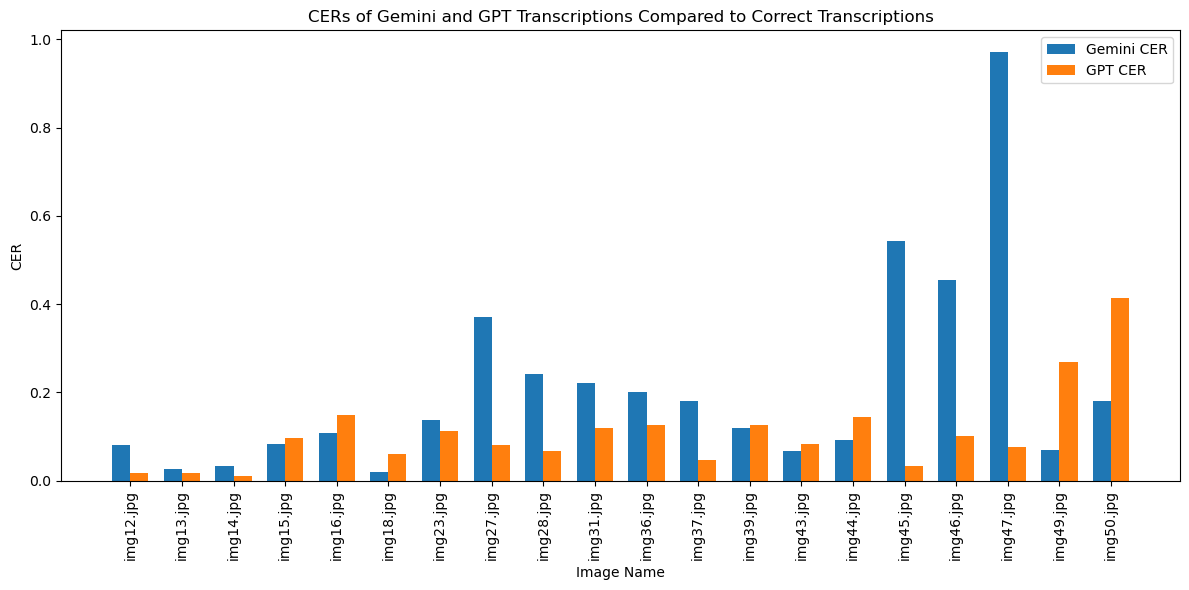

In [98]:
# Draw a bar plot comparing the CERs of Gemini and GPT for each image
plt.figure(figsize=(12, 6))
x = np.arange(len(image_names))
width = 0.35
plt.bar(x - width/2, gemini_cers, width, label='Gemini CER')
plt.bar(x + width/2, gpt_cers, width, label='GPT CER')
plt.xticks(x, image_names, rotation=90)
plt.xlabel('Image Name')
plt.ylabel('CER')
plt.title('CERs of Gemini and GPT Transcriptions Compared to Correct Transcriptions')
plt.legend()
plt.tight_layout()
plt.show()

From this analysis, I can see that there is definitely room for improvement with both GPT and Gemini. I can also see that both models did really well on certain images, while they both did poorly on others. However, there are also some images where one model did really well while the other did poorly. I show some of these images below.

**REMINDER**: The smaller the bar, the better the model performed on that image (since a lower CER is better).

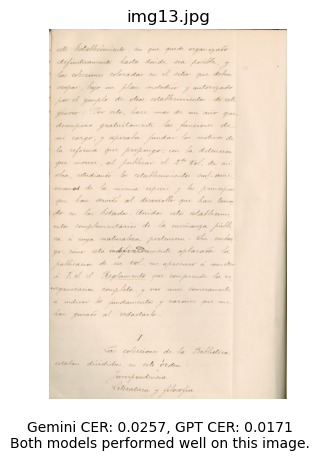

Gemini Transcript: este Establecimiento, sin que quede organizado\ndefinitivamente hasta donde sea posible, y\nlas colecciones colocadas en el sitio que deben\nocupar, bajo un plan metodico y autorizado\npor el ejemplo de otros establecimientos de este\ngenero. Por esto, hace mas de un año que\ndesempeño gratuitamente las funciones de\nmi cargo, y esperaba fundar los motivos de\nla reforma que propongo, con la detencion\nque merece, al publicar el 3r Vol. de mi\nobra, estudiando los establecimientos sud-ame-\nricanos de la misma especie y los principios\nque han servido al desarrollo que han toma-\ndo en los Estados-Unidos estos establecimi-\nentos complementarios de la enseñanza publi-\nca á cuya naturaleza pertenecen. Sin embar-\ngo, como está indefinidamente aplazada la\npublicacion de ese Vol., me apresuro á someter\ná V. E. el Reglamento que comprende la re-\norganizacion completa, y voi muy someramente\ná indicar los fundamentos y razones que me\nhan guiado al redactarlo.\n\nI\nL

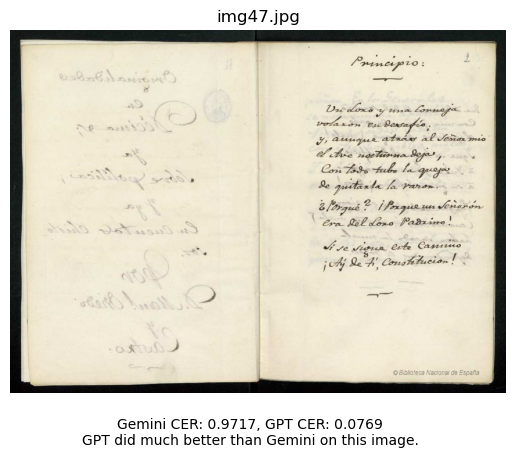

Gemini Transcript: [Left Page]\n\n(Text offset from the right page, appearing in reverse)\n\nOriginalidades\nen\nDécima y,\nya\nSobre politica;\ny ya\nen Cuentos Chisto\nsos.\n\nPor\nD. Man.l Oriedo\ny\nCastro.\n\n[Right Page]\n\nPrincipio: 2\nDos Loros y una Coneja\nvolaron en desafio,\ny, aunque atràs al S.or mio\nel Ave nocturna deja,\nCon todo tubo la queja\nde quitarla la varon:\n¿è Porque? ¡Porque un S.or non\nera del Loro Padrino!\n\nSi se sigue este Camino ¡Ay de tì, Constitucion!\n© Biblioteca Nacional de España
GPT Transcript: Principio:\nUn Loro y una Corneja\nvolaron en desafío,\ny, aunque atrajo al señor mío\nel ave nocturna vieja,\ncon todo tuvo la queja\nde quitarle la razón.\n¿Y porqué? ¡Porque un Señorón\nera del Loro Padrino!\nSi se sigue este Camino\n¡Ay de Hª, Constitución!\n


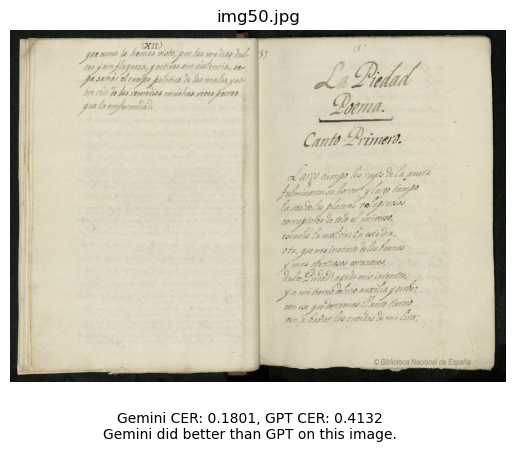

Gemini Transcript: [Left Page]\n\n(XII.)\nque como lo hemos visto, por las medras dul-\nces y sin flaqueza, y activas sin violencia, sa-\npa sanar el cuerpo politico de los males, y so-\nbre todo de las remedios muchas veces peores\nque la enfermedad.\n\n[Right Page]\n\n(1) La Piedad Poema. Canto Primero.\nLargo tiempo los vagos de la guerra\nfulminaron su horror: Y largo tiempo\nla sede de los placeres viciosos\ncorruptores de todo el universo,\nescondio la malicia: En este dia,\nò tu, que eres instituto de los buenos\ny mas afectuosos corazones,\nDulce Piedad! ayuda mis intentos,\ny a mi tierno labio auxilia y cede;\ncon ese que animas Canto tierno\nven a Cantar las cuerdas de mi Lira;\n\n© Biblioteca Nacional de España
GPT Transcript: La Piedad\nPoema.\nCanto Primero.\nLargo tiempo los rugidos de la guerra\nfulminaron su horror, y largo tiempo\nla voz de los placeres voluptuosos,\ncorruptores de todo el universo,\nescuchó la malicia: en este día,\noh tú, que eres instinto de las bue

In [103]:
# Show img13.jpg and the CERs for Gemini and GPT
img13_index = image_names.index('img13.jpg')
img13_gemini_ratio = gemini_cers[img13_index]
img13_gpt_ratio = gpt_cers[img13_index]
img13 = cv2.cvtColor(cv2.imread('Images/img13.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img13)
plt.title('img13.jpg')
plt.figtext(0.5, 0.01, f'Gemini CER: {img13_gemini_ratio:.4f}, GPT CER: {img13_gpt_ratio:.4f}\nBoth models performed well on this image.', horizontalalignment='center')
plt.axis('off')
plt.show()
print('Gemini Transcript:', parsed_rows[img13_index][2])
print('GPT Transcript:', parsed_rows[img13_index][3])

# Show img47.jpg and the CERs for Gemini and GPT
img47_index = image_names.index('img47.jpg')
img47_gemini_ratio = gemini_cers[img47_index]
img47_gpt_ratio = gpt_cers[img47_index]
img47 = cv2.cvtColor(cv2.imread('Images/img47.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img47)
plt.title('img47.jpg')
plt.figtext(0.5, 0.01, f'Gemini CER: {img47_gemini_ratio:.4f}, GPT CER: {img47_gpt_ratio:.4f}\nGPT did much better than Gemini on this image.', horizontalalignment='center')
plt.axis('off')
plt.show()
print('Gemini Transcript:', parsed_rows[img47_index][2])
print('GPT Transcript:', parsed_rows[img47_index][3])

# Show img50.jpg and the CERs for Gemini and GPT
img50_index = image_names.index('img50.jpg')
img50_gemini_ratio = gemini_cers[img50_index]
img50_gpt_ratio = gpt_cers[img50_index]
img50 = cv2.cvtColor(cv2.imread('Images/img50.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img50)
plt.title('img50.jpg')
plt.figtext(0.5, 0.01, f'Gemini CER: {img50_gemini_ratio:.4f}, GPT CER: {img50_gpt_ratio:.4f}\nGemini did better than GPT on this image.', horizontalalignment='center')
plt.axis('off')
plt.show()
print('Gemini Transcript:', parsed_rows[img50_index][2])
print('GPT Transcript:', parsed_rows[img50_index][3])

We can see that both models did very well on img13.jpg. I think that the script is relatively easy to read and there is not a lot of smudging or ink bleeding.

GPT did much better than Gemini on img47.jpg. One reason why is that Gemini included a note "(Text offset from the right page, appearing in reverse)" and included some text that had bled through from the back of the left side of the page. Also, Gemini included details about which page each part of the text was on. This image is tough because it has very dark ink that has bled through on the left side of the page.

In img50.jpg, Gemini did better than GPT. When we look at GPT's transcript for that page, we see that GPT skipped all of the text on the left side of the page. This image is difficult because the text is a bit lighter and the letters seem to flow together in a way that can make it more difficult to read and transcribe.

## Improvement

Since GPT was generally more successful in the transcriptions, I am going to work with OpenAI's API tool to try to improve GPT's performance. The first step in my improvement process is preprocessing the images to make them easier for the model to transcribe.

### Pre-Processing

I used ChatGPT to help me figure out what the best preprocessing steps were for my specific images and this specific scenario. These are the steps that I did to preprocess my images:

- Convert the image to grayscale
- Resize the image if it is huge so I don't use an unnecessary amount of API tokens
- Classify the image as clean or not based on if it is sharp or not and by the amount of noise and texture.
- Add a little bit of blur on noisy pages to help remove extra specks
- Remove uneven lighting using Gaussian blur
- Reduce bleed through
- Enhance the contrast to help with any fading ink or differing lighting
- Denoise noisy pages to remove any texture from the paper and any speckles
- Add a little bit of sharpness back to the edges

In [150]:
def grayscale(image):
    if len(image.shape) == 3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [151]:
def remove_uneven_lighting(image):
    # Estimate the background using a large Gaussian blur
    background = cv2.GaussianBlur(image, (41, 41), 0)
    corrected = cv2.divide(image, background, scale=255)
    corrected = np.clip(corrected, 0, 255).astype('uint8')
    return corrected

In [152]:
def reduce_bleed_through(image):
    # Strong blur
    bleed = cv2.GaussianBlur(image, (51, 51), 0)

    # Keep original detail (1.5×) and remove low-frequency bleed (-0.5×)
    no_bleed = cv2.addWeighted(image, 1.5, bleed, -0.5, 0)

    # Subtract the big blur
    no_bleed = np.clip(no_bleed, 0, 255).astype('uint8')

    return no_bleed

In [153]:
def enhance_contrast(image):
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8, 8))
    enhanced = clahe.apply(image)
    return enhanced

In [154]:
def denoise(image):
    # Non-local means denoising
    denoised = cv2.fastNlMeansDenoising(image, h=4)
    return denoised

In [155]:
def resize_if_huge(img, max_dim=2000):
    h, w = img.shape[:2]
    scale = max_dim / max(h, w)
    if scale < 1:
        img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    return img

In [156]:
def classify_page(image):
    # sharpness
    sharpness = cv2.Laplacian(image, cv2.CV_64F).var()

    # noise / texture
    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    residual = image.astype("float32") - blurred.astype("float32")
    noise_level = residual.std()

    is_clean = (sharpness > 120) and (noise_level < 20)

    return is_clean, sharpness, noise_level

In [157]:
def sharpen(image, amount=1.0, sigma=1.0):
    # Unsharp masking to restore crisp edges after processing
    blur = cv2.GaussianBlur(image, (0, 0), sigma)
    sharp = cv2.addWeighted(image, 1 + amount, blur, -amount, 0)
    sharp = np.clip(sharp, 0, 255).astype('uint8')
    return sharp

I put all of these steps together into one preprocessing function.

In [158]:
def preprocess_one_image(image_name):
    print(f"Processing image: {image_name}")

    # Load image
    image = cv2.imread(f"Images/{image_name}")
    if image is None:
        raise ValueError(f"Could not load image: {image_name}")

    # Grayscale
    gray = grayscale(image)

    # Resize if huge
    resized = resize_if_huge(gray, max_dim=2000)

    # Classify page as clean or noisy
    is_clean,_,_ = classify_page(resized)

    if is_clean:
        # For clean pages, keep strokes as sharp as possible
        base = resized # no extra blur
    else:
        # For noisy pages, a light median blur helps remove specks
        base = cv2.medianBlur(resized, 3)

    # Remove uneven lighting
    no_lighting = remove_uneven_lighting(base)

    # Reduce bleed-through
    no_bleed = reduce_bleed_through(no_lighting)

    # Enhance contrast
    enhanced = enhance_contrast(no_bleed)

    # Denoise
    if is_clean:
        # Clean pages already look good - skip heavy denoising
        denoised = enhanced
    else:
        # Noisy pages: do some denoising
        denoised = denoise(enhanced)

    # Add some sharpness back
    final = sharpen(denoised, amount=0.7, sigma=1.0)

    return final

To show how my preprocessing is working, I show the before and after on one of my images.

Processing image: img13.jpg


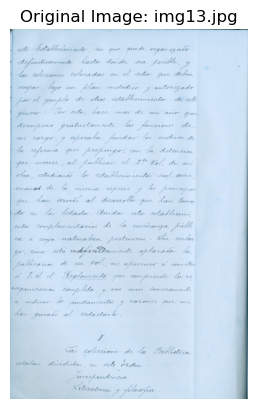

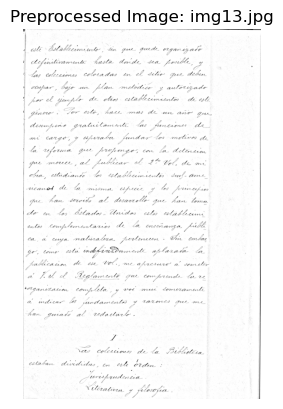

In [159]:
img_name = 'img13.jpg'
preprocessed_image = preprocess_one_image(img_name)
plt.imshow(cv2.imread(f"Images/{img_name}"), cmap='gray')
plt.title(f'Original Image: {img_name}')
plt.axis('off')
plt.show()
plt.imshow(preprocessed_image, cmap='gray')
plt.title(f'Preprocessed Image: {img_name}')
plt.axis('off')
plt.show()

From the above images, we can see that the preprocessing worked pretty well. It smoothed out some of the uneven lighting and discoloration that we can see in the original image. The preprocessed image has very few specks or other marks other than the letters, which are pretty dark and clear.

I ran my preprocessing function on all of my images. I saved the preprocessed version of each of the images in the `Images` folder in the `PreprocessedImages` folder.

In [161]:
# Process all of the images and put them in a plot
all_preprocessed_images = []
for img_name in image_names:
    preprocessed_img = preprocess_one_image(img_name)
    all_preprocessed_images.append(preprocessed_img)
    cv2.imwrite(f"PreprocessedImages/{img_name}", preprocessed_img)

Processing image: img12.jpg
Processing image: img13.jpg
Processing image: img14.jpg
Processing image: img15.jpg
Processing image: img16.jpg
Processing image: img18.jpg
Processing image: img23.jpg
Processing image: img27.jpg
Processing image: img28.jpg
Processing image: img31.jpg
Processing image: img36.jpg
Processing image: img37.jpg
Processing image: img39.jpg
Processing image: img43.jpg
Processing image: img44.jpg
Processing image: img45.jpg
Processing image: img46.jpg
Processing image: img47.jpg
Processing image: img49.jpg
Processing image: img50.jpg


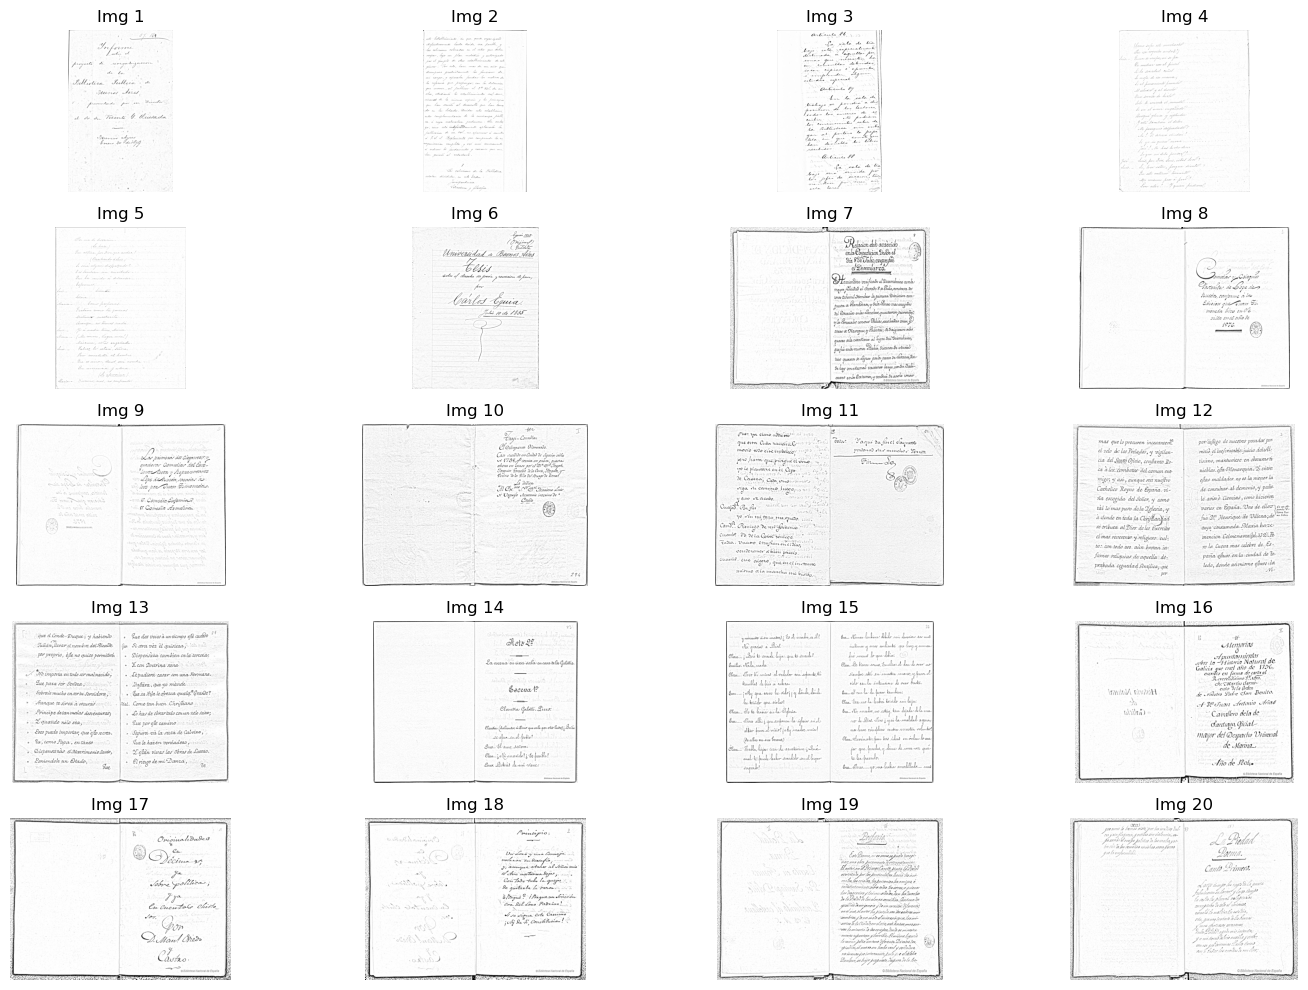

In [163]:
plt.figure(figsize=(15, 10))
for i, preprocessed_img in enumerate(all_preprocessed_images):
    plt.subplot(5, 4, i + 1)
    plt.imshow(preprocessed_img, cmap='gray')
    plt.title(f'Img {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### OpenAI's API

As the next part of my improvement step, I worked with OpenAI's API to try to improve the results that I originally got from ChatGPT.

In [168]:
OPENAI_KEY = os.environ.get('OPEN_AI_KEY')
client = OpenAI(api_key=OPENAI_KEY)

In [169]:
SYSTEM_MESSAGE = {
    "role": "system",
    "content": [
        {
            "type": "input_text",
            "text": (
                "You are an expert OCR model for 19th-century Spanish manuscripts. "
                "You must ALWAYS return a single valid JSON object with the keys "
                '"Transcription", "Confidence Score", "Error Analysis", "Steps Taken". '
                "Preserve original spelling and accents; do not modernize. "
                "Learn from prior examples in this conversation and avoid repeating past mistakes."
            ),
        }
    ],
}

In [238]:
BASE_PROMPT = """
Transcribe the attached image of a handwritten Spanish manuscript from the 1800s.

Keep the original spelling and accents exactly as written. Do NOT modernize the language.
If a word is unclear, write [illegible] instead of guessing. Ignore page numbers, marginal notes, and stamps.

Return your answer as valid JSON. Follow these rules strictly:
- Use double quotes for all keys and string values.
- Escape any double quote inside string values as \\".
- Represent newlines inside "Transcription", "Error Analysis", or "Steps Taken" as \\n, not as literal line breaks.

Other rules:
{global_rules}

Output ONLY a single JSON object in this exact format:
{{
"Transcription": "The raw, transcribed text (with \\n for newlines)",
"Confidence Score": "Provide an overall transcription confidence score (0.0 to 1.0)",
"Error Analysis": "In English, explain the primary paleographic and image-quality challenges encountered.",
"Steps Taken": "In English, detail the ordered steps you took to complete the transcription."
}}
""".strip()

The transcription step takes in an image, a prompt, and conversation history and gives it to the model which then outputs a JSON with the transcript of the image, along with other specified information.

In [171]:
def transcription_step(img_name, transcription_prompt, conversation_history):
    # Load the image
    img_path = f"PreprocessedImages/{img_name}"

    # Encode local image as base64
    with open(img_path, "rb") as image_file:
        b64_image = base64.b64encode(image_file.read()).decode("utf-8")

    # Build the new user turn (prompt + image)
    user_message = {
        "role": "user",
        "content": [
            {"type": "input_text", "text": transcription_prompt},
            {
                "type": "input_image",
                "image_url": f"data:image/jpeg;base64,{b64_image}",
            },
        ],
    }

    # Full input = prior history + this new message
    messages = conversation_history + [user_message]

    completion = client.responses.create(
        model="o4-mini",
        input=messages,
    )

    raw_transcription = completion.output_text
    conversation_history.append(user_message)
    conversation_history.append({
        "role": "assistant",
        "content": raw_transcription
    })

    return raw_transcription, conversation_history

The refine step takes in the prompt given to the transcription model, the transcription that it outputed (and information about that), and the correct transcription for that image. This step reflects on what went wrong and how it could improve in the future and outputs a JSON with one Step_To_Fix key which has a brief statement that should be added onto the prompt to help it improve in the future.

In [172]:
def refine_step(original_transcription_prompt, raw_transcription, correct_transcription, img_name):
    refine_prompt = f"""
    You are helping refine a transcription prompt.

    Here is the original transcription prompt the OCR model used:
    \"\"\"
    {original_transcription_prompt}
    \"\"\"

    Here is the OCR model's transcription:
    \"\"\"
    {json.loads(raw_transcription)['Transcription']}
    \"\"\"

    Here are the OCR model's steps that it took to do the transcription:
    \"\"\"
    {json.loads(raw_transcription)['Steps Taken']}
    \"\"\"

    Here is the OCR model's confidence score for its transcription:
    \"\"\"
    {json.loads(raw_transcription)['Confidence Score']}
    \"\"\"

    Here is the OCR model's error analysis of its transcription:
    \"\"\"
    {json.loads(raw_transcription)['Error Analysis']}
    \"\"\"

    Here is the correct transcription:
    \"\"\"
    {correct_transcription}
    \"\"\"

    Ignoring differences in spacing, tabs, newlines, and capitalization, silently compare the two transcriptions and think about the types of mistakes the OCR model made based on all of the information given. Silently think about the steps taken and where the OCR model could improve. Only output the refined instruction that should be added to the original prompt so the OCR model avoids those specific errors in the future. If applicable, describe the step in which the OCR model should make this change in its process. Do not repeat any part of the original prompt.

    Return your answer as valid JSON. Follow these rules strictly:
    - Use double quotes for all keys and string values.
    - Escape any double quote inside string values as \\".
    - Represent newlines inside "Step_To_Fix" as \\n, not as literal line breaks.

    Output ONLY a single JSON object in this exact format:
    {{"Step_To_Fix": "<concise improved instruction>"}}
    """.strip()

    # Send to GPT for refinement
    completion = client.responses.create(
        model="gpt-4.1-mini",
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": refine_prompt}
                ]
            }
        ],
    )

    refine_output = completion.output_text
    return refine_output

The following is the same comparison function that I used above, just copied down here for visibility and convenience. I decided to leave the [illegible] tokens in the text and include them in the CER calculation. This will give a penalty for any words marked as [illegible], which is what I want.

In [173]:
def compare_two_transcripts(reference, hypothesis):
    # Normalize each of the transcripts so that differences in spacing, tabs, newlines, or capitalization do not affect the comparison
    # Unicode normalization (for accents)
    reference = unicodedata.normalize("NFC", reference)
    hypothesis = unicodedata.normalize("NFC", hypothesis)

    # Ignore capitalization
    reference = reference.lower()
    hypothesis = hypothesis.lower()

    # Ignore newlines/tabs/inconsistent spacing
    reference = reference.replace("\n", " ")
    reference = reference.replace("\\n", " ")
    reference = reference.replace("\t", " ")
    reference = " ".join(reference.split())
    hypothesis = hypothesis.replace("\n", " ")
    hypothesis = hypothesis.replace("\\n", " ")
    hypothesis = hypothesis.replace("\t", " ")
    hypothesis = " ".join(hypothesis.split())

    # Calculate the Character Error Rate (CER)
    # 0.0 is the best (perfect match), 1.0 is the worst (completely different)
    return cer(reference, hypothesis)

The steps to process one image include:
- Run the transcription step for that image with the base prompt
- Find the correct transcription for that image
- Compare the original transcription with the correct transcription to get a baseline CER score
- Run the refine step to refine the prompt
- Add the new rule to the list of global rules
- Run the transcription step again with the updated prompt and conversation history
- Compare the refined transcription with the correct transcription to get an updated CER score
- Find the difference in the CER to determine if the score improved or not. (a negative change in CER is an improvement)

The model should be continuously learning throughout this process.

In [174]:
def pipeline_one_image(img_name, base_prompt, global_rules, conversation_history):
    print(f"IMAGE: {img_name}")

    current_prompt = base_prompt.format(global_rules=global_rules)
    original_transcription, conversation_history = transcription_step(img_name=img_name, transcription_prompt=current_prompt, conversation_history=conversation_history)
    original_dict = json.loads(original_transcription) # keys: Transcription, Confidence Score, Error Analysis, Steps Taken

    # Get the correct transcription
    df = pd.read_csv("transcripts.csv", engine="python", quotechar='"', skipinitialspace=True)
    df.columns = [c.strip().strip('"') for c in df.columns]
    correct_transcription = df.loc[df['file_name'] == img_name, 'Correct Transcript'].values[0]

    # Compare original transcription with correct transcription
    original_ratio = compare_two_transcripts(correct_transcription, original_dict["Transcription"])

    # Refine the prompt, parse the JSON output, and save the refined prompt
    refine_json = refine_step(original_transcription_prompt=current_prompt, raw_transcription=original_transcription, correct_transcription=correct_transcription, img_name=img_name)
    step_to_fix = json.loads(refine_json)["Step_To_Fix"]

    # Append the new global rule
    global_rules += step_to_fix

    # Tell the model what it just learned
    conversation_history.append({
        "role": "assistant",
        "content": (
            "Lesson learned from the previous image: "
            f"For all future images, permanently apply this refinement rule: {step_to_fix}"
        ),
    })

    refined_prompt = base_prompt.format(global_rules=global_rules)

    # Try transcription again with the refined prompt
    refined_transcription, conversation_history = transcription_step(img_name=img_name, transcription_prompt=refined_prompt, conversation_history=conversation_history)
    refined_dict = json.loads(refined_transcription)

    # Compare refined transcription with ground truth
    refined_ratio = compare_two_transcripts(correct_transcription, refined_dict["Transcription"])

    # Find difference in CER
    difference = refined_ratio - original_ratio # negative = improvement
    print(f"     Original CER: {original_ratio:.4f}, Refined CER: {refined_ratio:.4f}, Change in CER: {difference*100:.02f}%")

    # Return all important information
    return correct_transcription, original_transcription, step_to_fix, refined_transcription, original_ratio, refined_ratio, global_rules, conversation_history

To run my pipeline for all of my images, I run the pipeline for all of the images, saving all of the important data into a list of dictionaries.

In [175]:
def full_pipeline(train_file_list, base_prompt):
    # Shared rules and conversation across all images
    global_rules = "None."
    results = []

    # Start with a single system message; everything else gets appended
    conversation_history = [SYSTEM_MESSAGE]

    for img_name in train_file_list:
        correct_transcript, original_transcript, step_to_fix, refined_transcript, original_score, refined_score, gr, conversation_history = pipeline_one_image(img_name, base_prompt, global_rules, conversation_history)
        results.append({
            "image_name": img_name,
            "correct_transcript": correct_transcript,
            "original_transcript": original_transcript,
            "step_to_fix": step_to_fix,
            "refined_transcript": refined_transcript,
            "original_score": original_score,
            "refined_score": refined_score
        })
        global_rules = gr

    return results, global_rules, conversation_history

I wanted to only train my model on 75% of the images that I have (which is 15 out of the total 20 images). To do this, I created a training set which contains 15 random images and I also created a testing set which contains the remaining 5 random images.

In [176]:
# Get a list of the names of the images that I have transcribed
df = pd.read_csv("transcripts.csv", engine="python", quotechar='"', skipinitialspace=True)
df.columns = [c.strip().strip('"') for c in df.columns]
file_list = df["file_name"].tolist()

# Shuffle that list
np.random.seed(42)
np.random.shuffle(file_list)

# Split the image names into a training set (75%) and a testing set (25%)
train_file_list = file_list[:int(0.75 * len(file_list))]
test_file_list = file_list[int(0.75 * len(file_list)):]

In [177]:
print('Train File List:', train_file_list)
print('Test File List:', test_file_list)

Train File List: ['img12.jpg', 'img47.jpg', 'img45.jpg', 'img13.jpg', 'img28.jpg', 'img18.jpg', 'img37.jpg', 'img15.jpg', 'img49.jpg', 'img46.jpg', 'img43.jpg', 'img14.jpg', 'img31.jpg', 'img50.jpg', 'img16.jpg']
Test File List: ['img39.jpg', 'img27.jpg', 'img36.jpg', 'img44.jpg', 'img23.jpg']


I ran the full pipeline on all of the 15 images in the training set.

In [178]:
# Run the full pipeline on all 15 images in the training set
trained_results, trained_global_rules, trained_conversation_history = full_pipeline(train_file_list, BASE_PROMPT)

IMAGE: img12.jpg
     Original CER: 0.0405, Refined CER: 0.0520, Change in CER: 1.16%
IMAGE: img47.jpg
     Original CER: 0.0526, Refined CER: 0.0445, Change in CER: -0.81%
IMAGE: img45.jpg
     Original CER: 0.0548, Refined CER: 0.0968, Change in CER: 4.19%
IMAGE: img13.jpg
     Original CER: 0.0266, Refined CER: 0.0266, Change in CER: 0.00%
IMAGE: img28.jpg
     Original CER: 0.3193, Refined CER: 0.1024, Change in CER: -21.69%
IMAGE: img18.jpg
     Original CER: 0.0408, Refined CER: 0.0408, Change in CER: 0.00%
IMAGE: img37.jpg
     Original CER: 0.0674, Refined CER: 0.0652, Change in CER: -0.22%
IMAGE: img15.jpg
     Original CER: 0.1659, Refined CER: 0.0992, Change in CER: -6.67%
IMAGE: img49.jpg
     Original CER: 0.0538, Refined CER: 0.0503, Change in CER: -0.35%
IMAGE: img46.jpg
     Original CER: 0.1010, Refined CER: 0.0707, Change in CER: -3.03%
IMAGE: img43.jpg
     Original CER: 0.0600, Refined CER: 0.0520, Change in CER: -0.80%
IMAGE: img14.jpg
     Original CER: 0.0341, Re

I did some statistical and other analyses of the results that I got.

In [179]:
# Analyze change in CER (refined_score - original_score)
cer_changes = [res["refined_score"] - res["original_score"] for res in trained_results]
average_cer_change = sum(cer_changes) / len(cer_changes)
print(f"Average Change in CER: {average_cer_change*100:.2f}%")
print(f"Biggest Decline in CER: {max(cer_changes)*100:.2f}%")
print(f"Biggest Improvement in CER: {min(cer_changes)*100:.2f}%")

Average Change in CER: -2.34%
Biggest Decline in CER: 4.19%
Biggest Improvement in CER: -21.69%


From this we can see that the majority of the time, the refine step is improving the CER (making it smaller). This is a really large change in some cases, but a more subtle change in other cases.

In [180]:
# Analyze refined CERs
refined_cers = [res["refined_score"] for res in trained_results]
average_refined_cer = sum(refined_cers) / len(refined_cers)
print(f"Average Refined CER: {average_refined_cer*100:.2f}%")
print(f"Best Refined CER: {min(refined_cers)*100:.2f}%")
print(f"Worst Refined CER: {max(refined_cers)*100:.2f}%")

Average Refined CER: 8.50%
Best Refined CER: 2.66%
Worst Refined CER: 38.75%


In [266]:
print("Sorted Refined CERs:")
print(*sorted(refined_cers), sep='\n')

Sorted Refined CERs:
0.02664129400570885
0.04081632653061224
0.044534412955465584
0.04734848484848485
0.050292397660818715
0.052
0.05202312138728324
0.06430868167202572
0.06519337016574586
0.0707070707070707
0.07557117750439367
0.0967741935483871
0.0991869918699187
0.10240963855421686
0.387459807073955


From this, we can see that although the average refined CER is 8.50%, almost half of the refined CERs were 5% or lower. There is one refined CER of 38% which is really dragging the average upwards.

In [181]:
# Analyze confidence scores
original_confidence_scores = []
for res in trained_results:
    original_dict = json.loads(res["original_transcript"])
    confidence_score_str = original_dict["Confidence Score"]
    confidence_score = float(confidence_score_str)
    original_confidence_scores.append(confidence_score)
print(f"Average Original Confidence Score: {sum(original_confidence_scores) / len(original_confidence_scores):.2f}")
print(f"Max Original Confidence Score: {max(original_confidence_scores):.2f}")
print(f"Min Original Confidence Score: {min(original_confidence_scores):.2f}")

refined_confidence_scores = []
for res in trained_results:
    refined_dict = json.loads(res["refined_transcript"])
    confidence_score_str = refined_dict["Confidence Score"]
    confidence_score = float(confidence_score_str)
    refined_confidence_scores.append(confidence_score)
print(f"\nAverage Refined Confidence Score: {sum(refined_confidence_scores) / len(refined_confidence_scores):.2f}")
print(f"Max Refined Confidence Score: {max(refined_confidence_scores):.2f}")
print(f"Min Refined Confidence Score: {min(refined_confidence_scores):.2f}")

Average Original Confidence Score: 0.86
Max Original Confidence Score: 0.92
Min Original Confidence Score: 0.75

Average Refined Confidence Score: 0.87
Max Refined Confidence Score: 0.93
Min Refined Confidence Score: 0.80


It appears that the model became very slightly more confident after the Refine step, but there is not a huge difference.

In [182]:
# Analyze the error analyses provided by the model
print("Error Analyses provided by the model:")
for res in trained_results:
    original_dict = json.loads(res["original_transcript"])
    error_analysis = original_dict["Error Analysis"]
    print(f"\nImage {res['image_name']}: {error_analysis}")

Error Analyses provided by the model:

Image img12.jpg: The primary challenges were uneven ink density and background noise from paper degradation, which obscured faint strokes and punctuation. The 19th-century cursive letterforms, especially in "reorganizacion" and the date line, required careful distinction of similar shapes (e.g., long s vs. f-like forms). The comma after "Buenos Aires" was ambiguous, as was the accent placement in "reorganizacion," but modern accentuation was avoided in favor of preserving what is legible.

Image img47.jpg: The image exhibits uneven illumination and bleed-through from the verso, complicating the reading of fine diacritical marks (e.g. accents on “atrasó,” “Señorón,” and the question word “¿Porqué?”). The horizontal separators and marginal mirror-text risked being mistaken for text, and the ink fade made comma and period detection challenging. Paleographically, distinguishing capital initials (e.g. “Ave,” “Con,” “Camino”) and verifying whether words

We see that many of the images suffered from heavy bleed-through from the back of the paper which obscured the text that the model was trying to transcribe. There are also faint ruled lines on some of the pages which reduces the visibility of the handwriting and is often mistaken for handwriting strokes. Also, uneven ink density, fading, and poor lighting make small marks like accents, commas, and periods difficult for the model to be confident about.

From this, I would say that if there was a way to limit these types of issues, the model may perform better. So, if we have images without these issues, we can trust the model to perform better on them without as much human intervention. On the other hand, if we have images with these limitations, we may want to include more human intervention and checking when doing these transcriptions.


Correlation between confidence and CER: -0.5245
(CER is error, so a NEGATIVE correlation is good.)


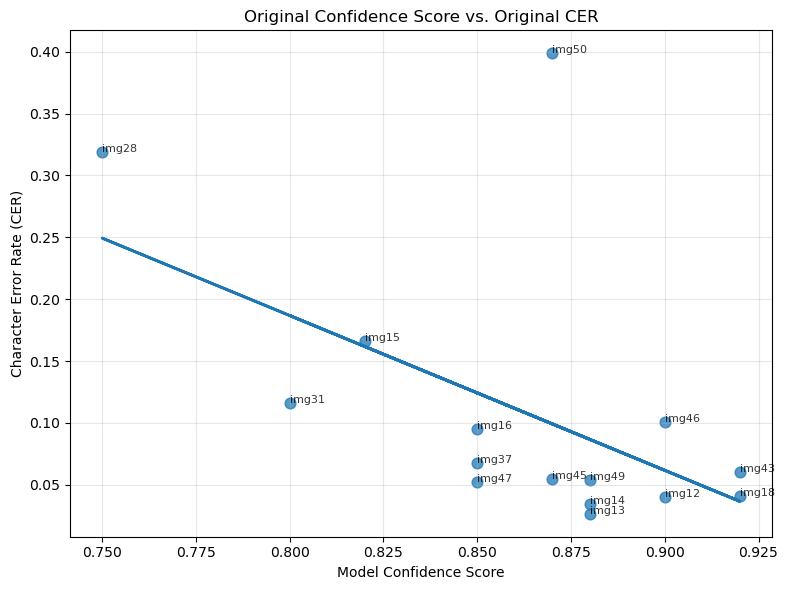

In [189]:
# Compare original confidence score vs original CER
original_cers = [res["original_score"] for res in trained_results]
# original_confidence_scores is already defined above
# train_file_list is already defined above
labels = [file_name[:-4] for file_name in train_file_list]

cer_values = np.array(original_cers)
conf_values = np.array(original_confidence_scores)

# --- Compute correlation ---
corr = np.corrcoef(conf_values, cer_values)[0, 1]
print(f"\nCorrelation between confidence and CER: {corr:.4f}")
print("(CER is error, so a NEGATIVE correlation is good.)")

# --- Regression line ---
m, b = np.polyfit(conf_values, cer_values, 1)
regression_y = m * conf_values + b

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(conf_values, cer_values, s=60, alpha=0.75)

# Plot regression line
plt.plot(conf_values, regression_y, linewidth=2)

# Annotate points with image names
for i, label in enumerate(labels):
    plt.annotate(label, (conf_values[i], cer_values[i]), fontsize=8, alpha=0.8)

plt.xlabel("Model Confidence Score")
plt.ylabel("Character Error Rate (CER)")
plt.title("Original Confidence Score vs. Original CER")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The correlation between model confidence and CER in the original transcription step is negative, which is what we want because a smaller CER is good. As the confidence of the model increases, the CER decreases, which makes sense. As my model is becoming more confident in its transcriptions, it is making fewer errors.


Correlation between confidence and CER: 0.0866
(CER is error, so a NEGATIVE correlation is good.)


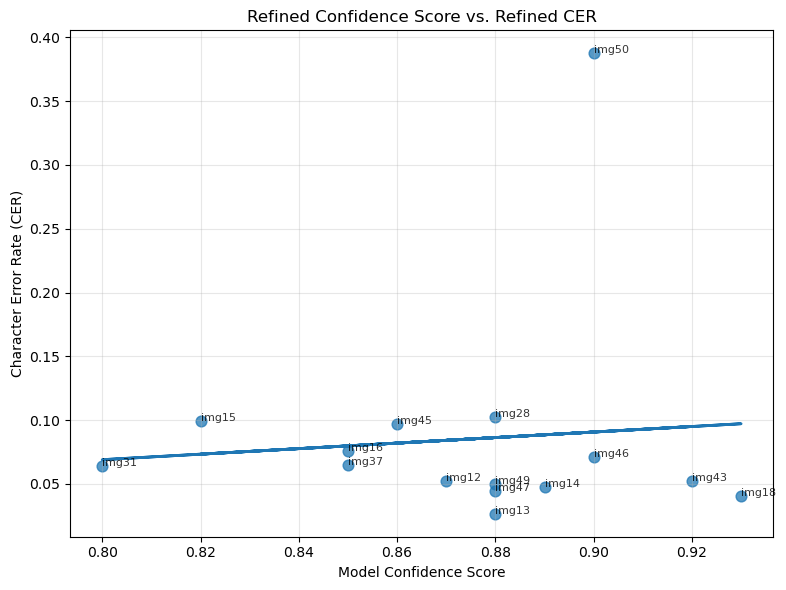

In [267]:
# Compare refined confidence score vs refined CER
refined_cers = [res["refined_score"] for res in trained_results]
# refined_confidence_scores is already defined above
# train_file_list is already defined above
labels = [file_name[:-4] for file_name in train_file_list]

cer_values = np.array(refined_cers)
conf_values = np.array(refined_confidence_scores)

# --- Compute correlation ---
corr = np.corrcoef(conf_values, cer_values)[0, 1]
print(f"\nCorrelation between confidence and CER: {corr:.4f}")
print("(CER is error, so a NEGATIVE correlation is good.)")

# --- Regression line ---
m, b = np.polyfit(conf_values, cer_values, 1)
regression_y = m * conf_values + b

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(conf_values, cer_values, s=60, alpha=0.75)

# Plot regression line
plt.plot(conf_values, regression_y, linewidth=2)

# Annotate points with image names
for i, label in enumerate(labels):
    plt.annotate(label, (conf_values[i], cer_values[i]), fontsize=8, alpha=0.8)

plt.xlabel("Model Confidence Score")
plt.ylabel("Character Error Rate (CER)")
plt.title("Refined Confidence Score vs. Refined CER")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Now, I am comparing the model confidence and the CER in the refined transcription step. This graph is a little bit weirder as the correlation is ever so slightly positive. However, when I look at the values in the bottom part of the graph, I see that they appear to be trending negative. So, I decided to remove the major outlier (img50) to see what the regression without this outlier would look like.


Correlation between confidence and CER: -0.4513
(CER is error, so a NEGATIVE correlation is good.)


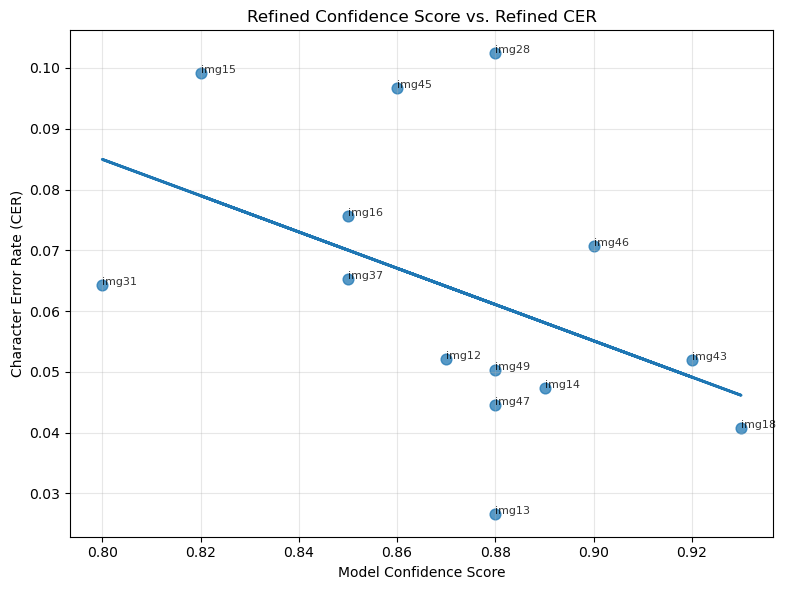

In [203]:
# Compare refined confidence score vs refined CER
refined_cers = [res["refined_score"] for res in trained_results]
# refined_confidence_scores is already defined above
# train_file_list is already defined above
labels = [file_name[:-4] for file_name in train_file_list]
labels = labels[:-2] + labels[-1:]

cer_values = np.array(refined_cers[:-2] + refined_cers[-1:])
conf_values = np.array(refined_confidence_scores[:-2] + refined_confidence_scores[-1:])

# --- Compute correlation ---
corr = np.corrcoef(conf_values, cer_values)[0, 1]
print(f"\nCorrelation between confidence and CER: {corr:.4f}")
print("(CER is error, so a NEGATIVE correlation is good.)")

# --- Regression line ---
m, b = np.polyfit(conf_values, cer_values, 1)
regression_y = m * conf_values + b

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(conf_values, cer_values, s=60, alpha=0.75)

# Plot regression line
plt.plot(conf_values, regression_y, linewidth=2)

# Annotate points with image names
for i, label in enumerate(labels):
    plt.annotate(label, (conf_values[i], cer_values[i]), fontsize=8, alpha=0.8)

plt.xlabel("Model Confidence Score")
plt.ylabel("Character Error Rate (CER)")
plt.title("Refined Confidence Score vs. Refined CER")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This is much better because now the correlation is negative, so when the model has high confidence, it is making fewer errors, which is what we want. Because this happens when we remove just one outlier, this tells me that in general, my model is performing the way that I want it to.

### Evaluate the model on my test set

At the beginning, I set aside 5 of the 20 images to be part of my test set and I didn't train the model on them. So, now I am going to evaluate how my model performs on the test set. To do this, I am just going to run the transcription step with all of the global rules and conversation history that I had gotten from my finished model. However, I am not going to run the refine step or the refined transcription step. I just want to see how my model does on images that it hasn't seen before.

In [204]:
def evaluate_on_test_set(test_file_list, base_prompt, global_rules, conversation_history):
    # I don't want test examples to change the training history, so copy the list
    conversation_history = list(conversation_history)

    # Read correct transcripts
    df = pd.read_csv("transcripts.csv", engine="python", quotechar='"', skipinitialspace=True)
    df.columns = [c.strip().strip('"') for c in df.columns]

    test_results = []

    for img_name in test_file_list:
        print(f"TEST IMAGE: {img_name}")

        # Build prompt with the learned global rules
        current_prompt = base_prompt.format(global_rules=global_rules)

        # Transcription step (NO refine step)
        raw_transcription, conversation_history = transcription_step(img_name=img_name, transcription_prompt=current_prompt, conversation_history=conversation_history)
        result_dict = json.loads(raw_transcription)

        # Correct transcript for this image
        correct_transcription = df.loc[df['file_name'] == img_name, 'Correct Transcript'].values[0]

        # Compute CER
        cer_score = compare_two_transcripts(correct_transcription, result_dict["Transcription"])
        print(f"     CER: {cer_score:.4f}")

        test_results.append({
            "image_name": img_name,
            "correct_transcript": correct_transcription,
            "model_transcript": result_dict["Transcription"],
            "confidence_score": result_dict["Confidence Score"],
            "error_analysis": result_dict["Error Analysis"],
            "steps_taken": result_dict["Steps Taken"],
            "cer": cer_score,
        })

    return test_results


In [206]:
# Evaluate on test set
test_results = evaluate_on_test_set(test_file_list, BASE_PROMPT, trained_global_rules, trained_conversation_history)

TEST IMAGE: img39.jpg
     CER: 0.0967
TEST IMAGE: img27.jpg
     CER: 0.0726
TEST IMAGE: img36.jpg
     CER: 0.0948
TEST IMAGE: img44.jpg
     CER: 0.0864
TEST IMAGE: img23.jpg
     CER: 0.0874


In [272]:
test_set_results = {'img39.jpg':0.0967, 'img27.jpg':0.0726, 'img36.jpg':0.0948, 'img44.jpg':0.0864, 'img23.jpg':0.0874}

We can see that overall, my model performed pretty well on these new images. They got between a 7-9% CER, which is great.

Now, I am going to compare the CERs from my model to the CER from the transcription that I got from ChatGPT's website originally.

In [268]:
images = ['img39.jpg', 'img27.jpg', 'img36.jpg', 'img44.jpg', 'img23.jpg']

cers = {}

for img in images:
    # Look at the transcripts from transcripts.csv
    df = pd.read_csv("transcripts.csv", engine="python", quotechar='"', skipinitialspace=True)
    df.columns = [c.strip().strip('"') for c in df.columns]

    # Get the original GPT transcript
    gpt_transcript = df.loc[df['file_name'] == img, 'GPT Transcript'].values[0]

    # Get the correct transcript
    correct_transcript = df.loc[df['file_name'] == img, 'Correct Transcript'].values[0]

    # Calculate the CER of the GPT transcript
    gpt_cer = compare_two_transcripts(correct_transcript, gpt_transcript)

    print(img, gpt_cer)
    cers[img] = gpt_cer

img39.jpg 0.12598425196850394
img27.jpg 0.08064516129032258
img36.jpg 0.12577319587628866
img44.jpg 0.14312267657992564
img23.jpg 0.11349693251533742


In [283]:
print("Image \ Original GPT CER \ My model CER:\n")
for img in images:
    print(f"{img} \ {cers[img]:.4f} \ {test_set_results[img]:.4f}")
print(f"\nAverages \ {np.mean(list(cers.values())):.4f} \ {np.mean(list(test_set_results.values())):.4f}")

Image \ Original GPT CER \ My model CER:

img39.jpg \ 0.1260 \ 0.0967
img27.jpg \ 0.0806 \ 0.0726
img36.jpg \ 0.1258 \ 0.0948
img44.jpg \ 0.1431 \ 0.0864
img23.jpg \ 0.1135 \ 0.0874

Averages \ 0.1178 \ 0.0876


From this, we can see that originally, these 5 test images had a CER of around 11.78%. However, with my model, they have an average CER or 8.76%. This around 3% improvement may not seem like very much, but considering that I only trained the model on 15 images, I would say that these are pretty good results. I believe that if I was able to train my model on more images and images that were more difficult to read (that maybe a professional could read instead of me), this type of model could be very helpful.

# DEMO

### Display an image that my model was not trained on

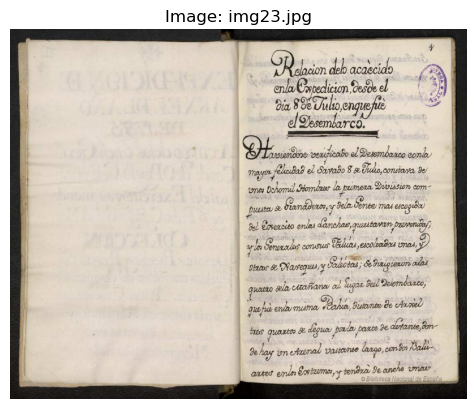

In [255]:
# Choose an image from the test set to display results for
img_name = 'img23.jpg'

# Display the image
img = cv2.cvtColor(cv2.imread(f"Images/{img_name}"), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f'Image: {img_name}')
plt.axis('off')
plt.show()


### Calculate the baseline CER

In [256]:
# Look at the transcripts from transcripts.csv
df = pd.read_csv("transcripts.csv", engine="python", quotechar='"', skipinitialspace=True)
df.columns = [c.strip().strip('"') for c in df.columns]

# Get the original GPT transcript
gpt_transcript = df.loc[df['file_name'] == img_name, 'GPT Transcript'].values[0]

# Get the correct transcript
correct_transcript = df.loc[df['file_name'] == img_name, 'Correct Transcript'].values[0]

# Calculate the CER of the GPT transcript
gpt_cer = compare_two_transcripts(correct_transcript, gpt_transcript)

print(f'CER of original GPT transcript: {gpt_cer:.5f} ({gpt_cer*100:.2f}%)')

CER of original GPT transcript: 0.11350 (11.35%)


Generally with CER, under 5% is considered very good.

### Run the image through my model to try to get an improvement in the CER

In [234]:
def evaluate_on_one_test_image(img_name, base_prompt, global_rules, conversation_history):
    # I don't want test examples to change the training history, so copy the list
    conversation_history = list(conversation_history)

    print(f"TEST IMAGE: {img_name}")

    # Build prompt with the learned global rules
    current_prompt = base_prompt.format(global_rules=global_rules)

    # Transcription step (NO refine step)
    raw_transcription, conversation_history = transcription_step(img_name=img_name, transcription_prompt=current_prompt, conversation_history=conversation_history)
    result_dict = json.loads(raw_transcription)

    # Get the correct transcript for this image
    df = pd.read_csv("transcripts.csv", engine="python", quotechar='"', skipinitialspace=True)
    df.columns = [c.strip().strip('"') for c in df.columns]
    correct_transcription = df.loc[df['file_name'] == img_name, 'Correct Transcript'].values[0]

    # Compute CER
    cer_score = compare_two_transcripts(correct_transcription, result_dict["Transcription"])
    print(f"     CER: {cer_score:.4f} ({cer_score*100:.2f}%)")

    test_results = {
        "image_name": img_name,
        "correct_transcript": correct_transcription,
        "model_transcript": result_dict["Transcription"],
        "confidence_score": result_dict["Confidence Score"],
        "error_analysis": result_dict["Error Analysis"],
        "steps_taken": result_dict["Steps Taken"],
        "cer": cer_score,
    }

    return test_results


In [258]:
test_results = evaluate_on_one_test_image('img23.jpg', BASE_PROMPT, trained_global_rules, trained_conversation_history)

TEST IMAGE: img23.jpg
     CER: 0.0752 (7.52%)


# Acknowledgements

See my report for a full list of acknowledgements.